# KNN Image Dataset

### Import Libraries and Modules

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc, 
    precision_recall_curve, 
    average_precision_score
)
from tensorflow.keras.utils import to_categorical
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, learning_curve
from PIL import Image, UnidentifiedImageError
from scipy.io import loadmat
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, label_binarize


### Load and Process Labels

In [28]:
labels = loadmat('imagelabels.mat')['labels'][0]
labels -= 1  

unique_labels, label_counts = np.unique(labels, return_counts=True)
print("Original Label Distribution:")
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} samples")


Original Label Distribution:
Label 0: 40 samples
Label 1: 60 samples
Label 2: 40 samples
Label 3: 56 samples
Label 4: 65 samples
Label 5: 45 samples
Label 6: 40 samples
Label 7: 85 samples
Label 8: 46 samples
Label 9: 45 samples
Label 10: 87 samples
Label 11: 87 samples
Label 12: 49 samples
Label 13: 48 samples
Label 14: 49 samples
Label 15: 41 samples
Label 16: 85 samples
Label 17: 82 samples
Label 18: 49 samples
Label 19: 56 samples
Label 20: 40 samples
Label 21: 59 samples
Label 22: 91 samples
Label 23: 42 samples
Label 24: 41 samples
Label 25: 41 samples
Label 26: 40 samples
Label 27: 66 samples
Label 28: 78 samples
Label 29: 85 samples
Label 30: 52 samples
Label 31: 45 samples
Label 32: 46 samples
Label 33: 40 samples
Label 34: 43 samples
Label 35: 75 samples
Label 36: 108 samples
Label 37: 56 samples
Label 38: 41 samples
Label 39: 67 samples
Label 40: 127 samples
Label 41: 59 samples
Label 42: 130 samples
Label 43: 93 samples
Label 44: 40 samples
Label 45: 196 samples
Label 46: 6

### Preprocess and Clean Image Data

In [29]:
image_dir = 'jpg/'
image_paths = [os.path.join(image_dir, f'image_{i:05d}.jpg') for i in range(1, len(labels) + 1)]

cleaned_images = []
cleaned_labels = []

IMG_SIZE = 128  

for i, img_path in enumerate(image_paths):
    try:
        img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE)).convert('L')
        img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
        if img_array.shape == (IMG_SIZE, IMG_SIZE):  
            cleaned_images.append(img_array)
            cleaned_labels.append(labels[i])
    except UnidentifiedImageError:
        print(f"Skipped corrupted image: {img_path}")

cleaned_images = np.array(cleaned_images).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
cleaned_labels = np.array(cleaned_labels)

print(f"\nTotal Cleaned Images: {len(cleaned_images)}")



Total Cleaned Images: 8189


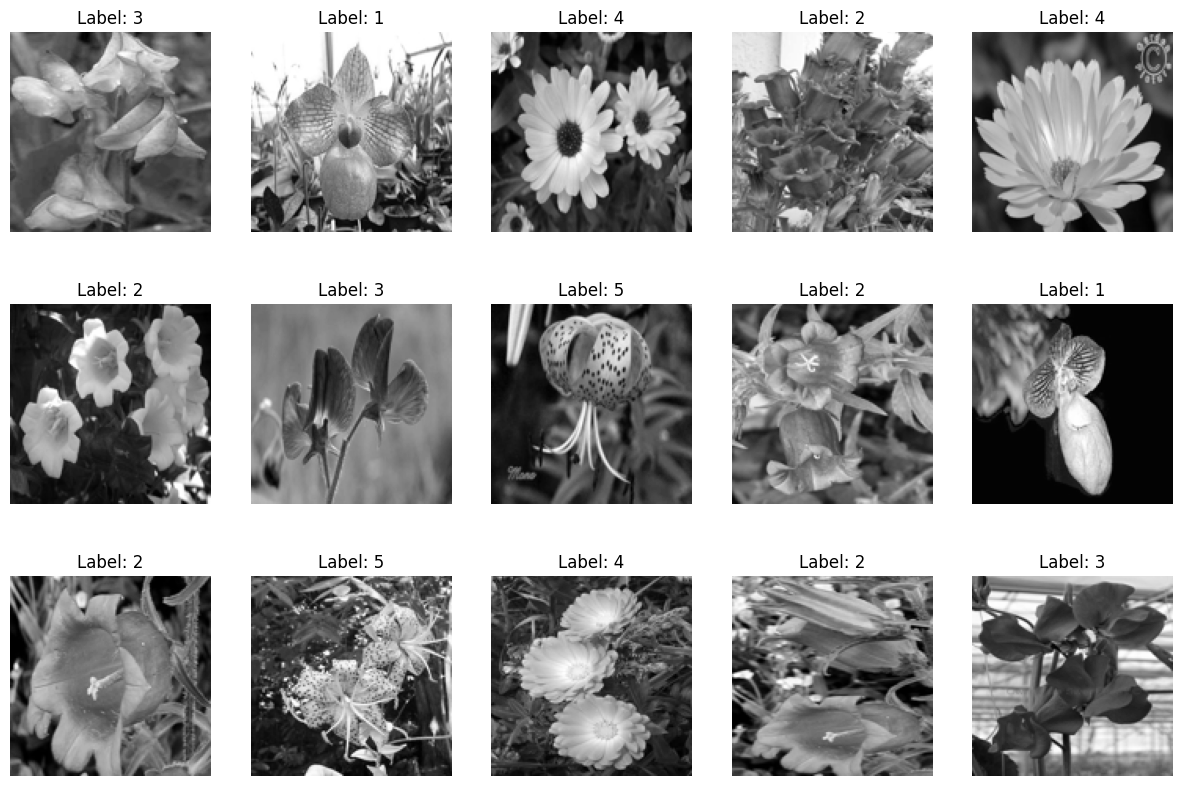

In [30]:
filtered_indices = np.where((cleaned_labels >= 1) & (cleaned_labels <= 5))[0]

plt.figure(figsize=(15, 10))
selected_indices = np.random.choice(filtered_indices, 15, replace=False)

for i, idx in enumerate(selected_indices):
    plt.subplot(3, 5, i+1)
    plt.imshow(cleaned_images[idx].squeeze(), cmap='gray')
    plt.title(f"Label: {cleaned_labels[idx]}")
    plt.axis('off')

plt.show()

In [31]:
unique_cleaned_labels, cleaned_label_counts = np.unique(cleaned_labels, return_counts=True)
print("\nCleaned Label Distribution:")
for label, count in zip(unique_cleaned_labels, cleaned_label_counts):
    print(f"Label {label}: {count} samples")



Cleaned Label Distribution:
Label 0: 40 samples
Label 1: 60 samples
Label 2: 40 samples
Label 3: 56 samples
Label 4: 65 samples
Label 5: 45 samples
Label 6: 40 samples
Label 7: 85 samples
Label 8: 46 samples
Label 9: 45 samples
Label 10: 87 samples
Label 11: 87 samples
Label 12: 49 samples
Label 13: 48 samples
Label 14: 49 samples
Label 15: 41 samples
Label 16: 85 samples
Label 17: 82 samples
Label 18: 49 samples
Label 19: 56 samples
Label 20: 40 samples
Label 21: 59 samples
Label 22: 91 samples
Label 23: 42 samples
Label 24: 41 samples
Label 25: 41 samples
Label 26: 40 samples
Label 27: 66 samples
Label 28: 78 samples
Label 29: 85 samples
Label 30: 52 samples
Label 31: 45 samples
Label 32: 46 samples
Label 33: 40 samples
Label 34: 43 samples
Label 35: 75 samples
Label 36: 108 samples
Label 37: 56 samples
Label 38: 41 samples
Label 39: 67 samples
Label 40: 127 samples
Label 41: 59 samples
Label 42: 130 samples
Label 43: 93 samples
Label 44: 40 samples
Label 45: 196 samples
Label 46: 6

### Filter and Remap Labels for Specific Classes

In [32]:
selected_classes = [0, 1, 2, 3, 4]
mask = np.isin(cleaned_labels, selected_classes)

filtered_images = cleaned_images[mask]
filtered_labels = cleaned_labels[mask]

label_mapping = {old_label: new_label for new_label, old_label in enumerate(selected_classes)}
filtered_labels = np.array([label_mapping[label] for label in filtered_labels])

unique_filtered_labels, filtered_label_counts = np.unique(filtered_labels, return_counts=True)
print("\nFiltered Label Distribution:")
for label, count in zip(unique_filtered_labels, filtered_label_counts):
    print(f"Class {label}: {count} samples")



Filtered Label Distribution:
Class 0: 40 samples
Class 1: 60 samples
Class 2: 40 samples
Class 3: 56 samples
Class 4: 65 samples


### Balance Dataset Using Oversampling

In [33]:
balanced_images = []
balanced_labels = []
max_samples = 200  

for cls in range(len(selected_classes)):
    cls_mask = filtered_labels == cls
    cls_images = filtered_images[cls_mask]
    cls_labels = filtered_labels[cls_mask]
    
    resampled_cls_images, resampled_cls_labels = resample(
        cls_images, cls_labels, n_samples=max_samples, random_state=42
    )
    balanced_images.extend(resampled_cls_images)
    balanced_labels.extend(resampled_cls_labels)

balanced_images = np.array(balanced_images)
balanced_labels = np.array(balanced_labels)

unique_balanced_labels, balanced_label_counts = np.unique(balanced_labels, return_counts=True)
print("\nBalanced Label Distribution:")
for label, count in zip(unique_balanced_labels, balanced_label_counts):
    print(f"Class {label}: {count} samples")



Balanced Label Distribution:
Class 0: 200 samples
Class 1: 200 samples
Class 2: 200 samples
Class 3: 200 samples
Class 4: 200 samples


### Encode Labels and Split Dataset

In [34]:
balanced_labels_one_hot = to_categorical(balanced_labels, num_classes=len(selected_classes))

X_train, X_test, y_train, y_test = train_test_split(
    balanced_images, balanced_labels, test_size=0.3, random_state=42
)
print("\nDataset Split:")
print(f"Training Images: {len(X_train)}")
print(f"Testing Images: {len(X_test)}")



Dataset Split:
Training Images: 700
Testing Images: 300


### Training Set Label Distribution

In [35]:
unique_train_labels, train_label_counts = np.unique(y_train, return_counts=True)
print("\nTraining Set Label Distribution:")
for label, count in zip(unique_train_labels, train_label_counts):
    print(f"Class {label}: {count} samples")



Training Set Label Distribution:
Class 0: 145 samples
Class 1: 129 samples
Class 2: 143 samples
Class 3: 147 samples
Class 4: 136 samples


### Testing Set Label Distribution

In [36]:
unique_test_labels, test_label_counts = np.unique(y_test, return_counts=True)
print("\nTesting Set Label Distribution:")
for label, count in zip(unique_test_labels, test_label_counts):
    print(f"Class {label}: {count} samples")



Testing Set Label Distribution:
Class 0: 55 samples
Class 1: 71 samples
Class 2: 57 samples
Class 3: 53 samples
Class 4: 64 samples


### Flatten and Standardize the Images for KNN

In [37]:
X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Train KNN and Evaluate Performance

In [38]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

from sklearn.metrics import accuracy_score,log_loss
print('Accuracy: ',accuracy_score(y_test,y_pred))
loss_value = log_loss(y_test, knn.predict_proba(X_test))
print(f"Loss Value: {loss_value:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in selected_classes]))



Accuracy:  0.8633333333333333
Loss Value: 1.0681

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.69      0.98      0.81        55
     Class 1       0.98      0.83      0.90        71
     Class 2       0.93      0.91      0.92        57
     Class 3       0.98      0.81      0.89        53
     Class 4       0.82      0.80      0.81        64

    accuracy                           0.86       300
   macro avg       0.88      0.87      0.87       300
weighted avg       0.88      0.86      0.87       300



### Confusion Matrix Visualization

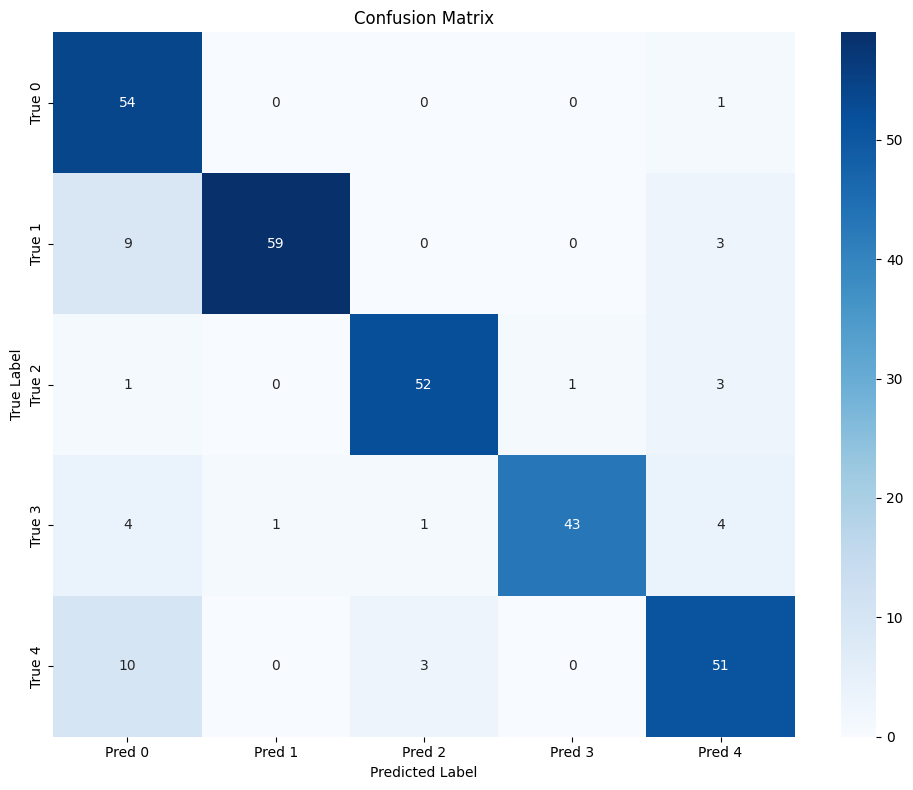

[[54  0  0  0  1]
 [ 9 59  0  0  3]
 [ 1  0 52  1  3]
 [ 4  1  1 43  4]
 [10  0  3  0 51]]


In [39]:
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Pred {i}' for i in selected_classes],
            yticklabels=[f'True {i}' for i in selected_classes])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
print(conf_matrix)


### ROC and AUC

Class 0: AUC = 0.97
Class 1: AUC = 0.99
Class 2: AUC = 1.00
Class 3: AUC = 0.97
Class 4: AUC = 0.95

Average AUC: 0.98


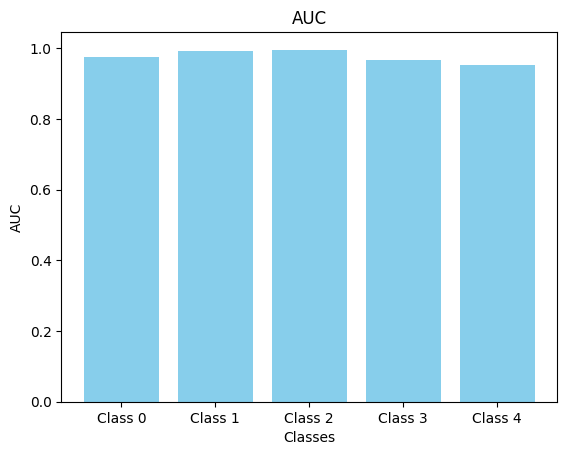

In [40]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_proba = knn.predict_proba(X_test)
auc_values = []
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    auc_values.append(roc_auc)
    print(f"Class {i}: AUC = {roc_auc:.2f}")

average_auc = np.mean(auc_values)
print(f"\nAverage AUC: {average_auc:.2f}")
classes = [f'Class {i}' for i in range(y_test_bin.shape[1])]
plt.bar(classes, auc_values, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('AUC')
plt.title('AUC')

plt.show()



### Precision-Recall Curve and Average Precision

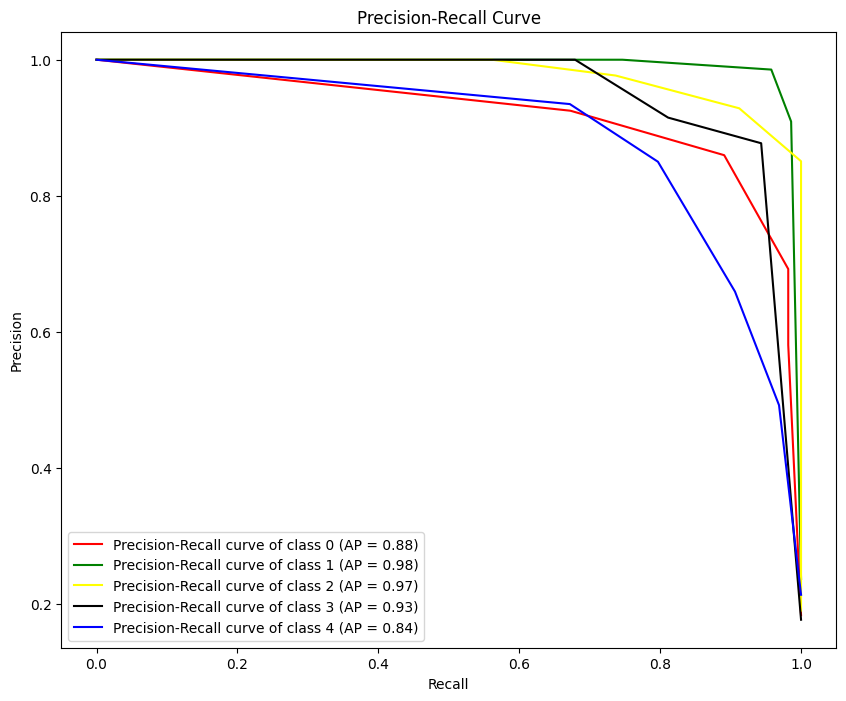

In [42]:
plt.figure(figsize=(10, 8))
for i, color in zip(range(len(selected_classes)), ['red','green','yellow','black','blue']):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, color=color, 
             label=f'Precision-Recall curve of class {i} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()